# 07-3. 신경망 모델 훈련(p.392)

## 손실 곡선

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
# 패션 MNIST
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer) # model_fn() 함수에 (a_layer 매개변수로) 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [3]:
model = model_fn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# fit() 메서드의 결과를 history 변수에 담음
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [7]:
print(history.history.keys()) # 훈련 측정값이 담겨있는 history 딕셔너리 확인
# 손실, 정확도가 포함되어 있음

dict_keys(['accuracy', 'loss'])


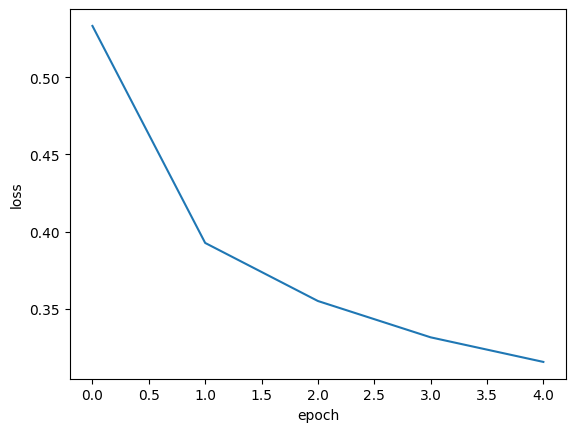

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
# 5개 에포크: 0~4

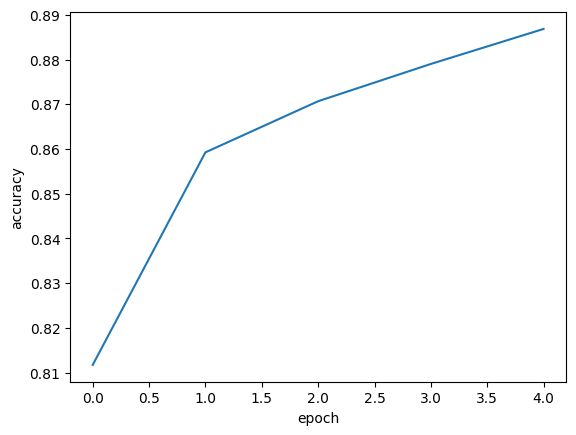

In [9]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


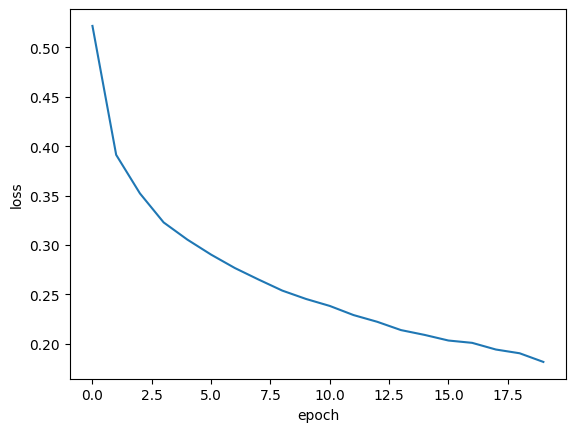

In [10]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0) # 에포크 늘림
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실
- 검증 손실을 사용해 과대/과소적합 확인.
- 인공신경망 모델이 최적화하는 대상은 정확도가 아닌 손실 함수. 손실 삼소에 비례해 정확도가 높아지지 않는 경우도 있어, 모델의 훈련 정도는 손실함수의 값을 확인하는 것이 더 낫다.

In [11]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
print(history.history.keys())
# 검증 손실 및 정확도 포함됨

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


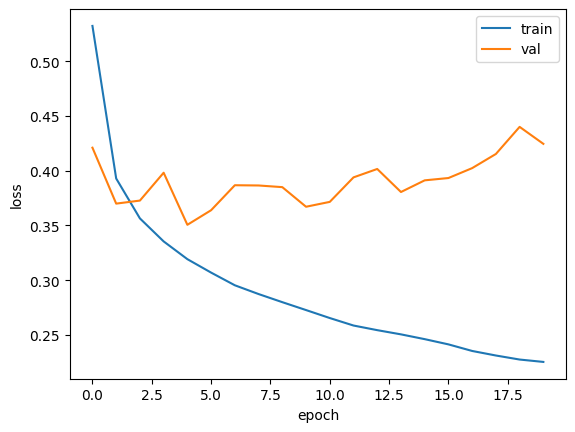

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# 다섯 번째 에포크만에 검증 손실 상승, 훈련손실은 꾸준히 감소 -> 과대적합.
# 검증손실 상승 시점을 뒤로 늦추어야 검증세트에 대한 손실 줄어듦+검증세트의 정확도 증가할 것.

과대적합 방지: 옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시킬 수 있는가.

RMSprop 옵티마이저는 많은 문제에서 잘 작동, 다른 옵티마이저를 사용하고 싶다면 Adam. 적응적 학습률을 사용하므로 에포크가 진행되면서 학습률의 크기를 조정할 수 있음.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


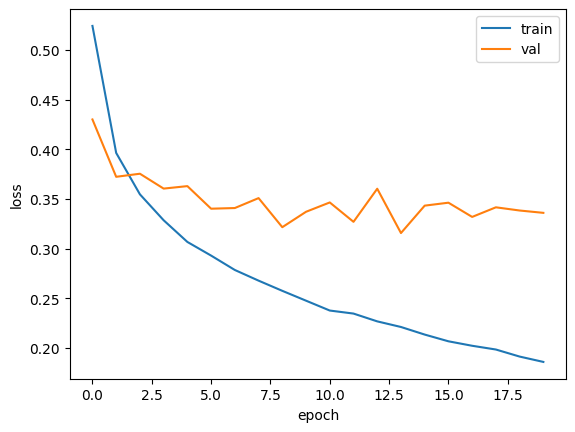

In [14]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# 과적합 훨씬 줄음.

## 드롭아웃
훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막음.

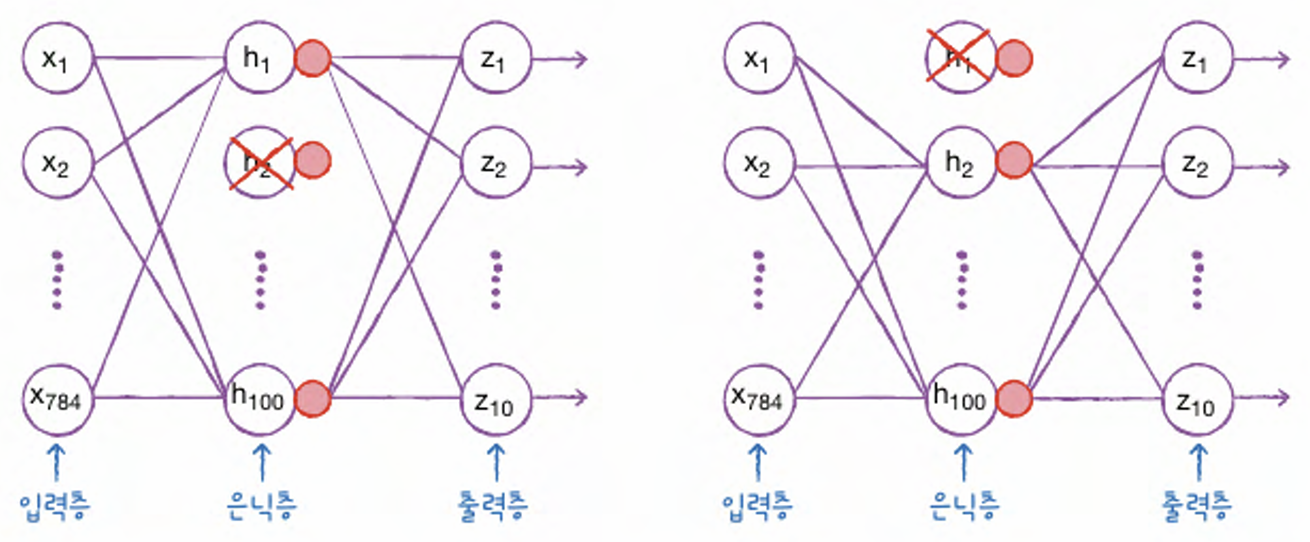

샘플마다 랜덤하게 드롭아웃됨, 얼마나 많은 뉴런을 드롭할지 정하는 하이퍼파라미터.

드롭아웃이 과대적합을 막을 수 있는 이유: 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과도하게 의존하는 것을 줄이고 모든 입력에 대해 주의를 기울임.

keras.layers 패키지 아래 Dropout 클래스로 드롭아웃 제공. 어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만듦.



In [15]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()
# 드롭아웃층은 훈련되는 모델 파라미터가 없음, 입출력 크기가 같음.
# 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않음.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

훈련이 끝난 뒤의 평가 및 예측 수행시에는 드롭아웃 적용 X. 훈련된 모든 뉴런을 사용해야 올바른 예측 수행이 가능함.

텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃 적용하지 않음.

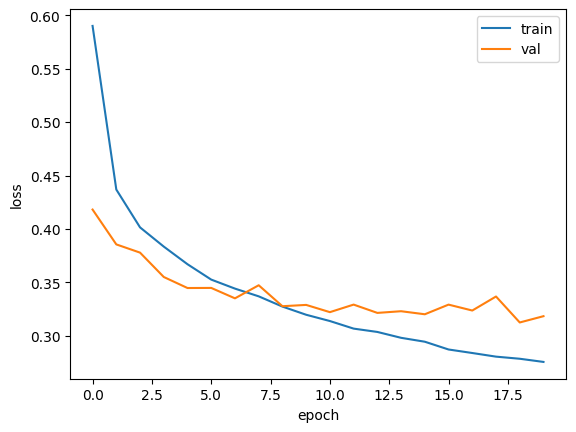

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원
- save_weights() 메서드: 훈련된 모델의 파라미터 저장. 기본적으로는 텐서플로의 체크포인트 포맷으로 저장, 파일 확장자가 '.h5'일 경우 HDF5 포맷으로 저장함.
- save() 메서드: 텐서플로의 SavedModel 포맷으로 저장, 파일 확장자가 '.h5'일 경우 HDF5 포맷으로 저장함.

In [18]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

In [21]:
model.save_weights('model.weights.h5')

In [22]:
model.save('model-whole.h5')

In [23]:
!ls -al *.h5 # 두 파일이 잘 만들어졌는지 확인
# 셀 명령을 실행할 때 ! 사용

-rw-r--r-- 1 root root 976600 Apr  2 16:22 model.weights.h5
-rw-r--r-- 1 root root 978584 Apr  2 16:22 model-whole.h5


In [25]:
model = model_fn(keras.layers.Dropout(0.3)) # 새 모델 만듦
model.load_weights('model.weights.h5') # 이전에 저장했던 모델 파라미터 적재: load_weights()

save_weights() 메서드로 저장했던 모델 파라미터를 load_weights() 메서드로 새 모델에 적재한다.

load_weights() 메서드를 사용하려면, save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야 한다. 여기에서는 model_fn() 함수를 사용하여 동일 모델을 만들어 사용했다.

predict() 메서드: 케라스에서 예측 수행하는 메서드. 사이킷런과 달리, 샘플마다 10개 클래스에 대한 확률을 반환함.

evaluate() 메서드: 모델 파라미터를 읽은 후 evaluate() 메서드로 정확도 출력도 가능하나, 손실을 계산하기 위해 반드시 먼저 compile() 메서드를 실행해야 함.

In [26]:
import numpy as np
# 10개 확률 중 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
# numpy argmax() 함수: 배열에서 가장 큰 값의 인덱스 반환
print(np.mean(val_labels == val_target))

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.8823333333333333


axis=-1: 배열의 마지막 차원을 따라 최댓값을 고름, 검증 세트는 2차원 배열이므로 마지막 차원은 1이 됨, axis=1과 같음.

axis=1이면 열을 따라 각 행의 최댓값의 인덱스를 선택하고, axis=0이면 행을 따라 각 열의 최댓값의 인덱스를 선택,  
argmax()로 고른 인덱스(val_labels)와 타깃(val_target)을 비교, 두 배열에서 각 위치의 값이 같으면 1, 다르면 0이 됨 = 평균이 정확도.

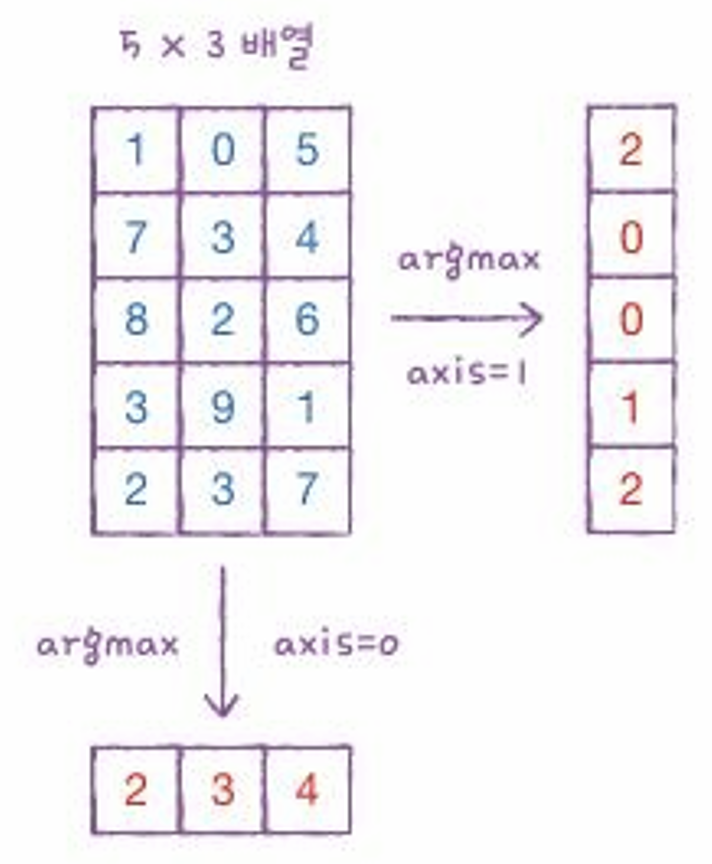

In [27]:
# load_model(): 모델이 저장된 파일 읽기
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)
# 같은 모델을 저장하고 다시 불러들였으므로 동일한 정확도가 나옴.

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8840 - loss: 0.3320


[0.33145856857299805, 0.8823333382606506]

## 콜백
훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체.

In [30]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])
# ModelCheckpoint 클래스의 객체 checkpoint_cb를 만든 후, fit() 메서드의 callbacks 매개변수에 리스트로 감싸서 전달

In [31]:
model = keras.models.load_model('best-model.h5') # 최상의 검증 점수를 낸 모델이 저장됨
model.evaluate(val_scaled, val_target) # 다시 불러와서 예측

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8894 - loss: 0.3208


[0.3210763931274414, 0.887333333492279]

**조기종료**: 과대적합이 시작되기 전 훈련을 미리 중지하는 것. 검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지므로 훈련을 계속할 필요 없음, 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있음.

케라스의 EarlyStopping 콜백-patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수 지정. patience=2면, 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지. restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림.

EarlyStopping 콜백과 ModelCheckpoint 콜백을 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고, 검증손실이 다시 상승할 때 훈련 중지. 그후 현재 모델의 파라미터를 최상의 파라미터로 되돌림.

In [34]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
print(early_stopping_cb.stopped_epoch)
# 몇 번째 에포크에서 훈련이 중지되었는가: 열두 번째.

11


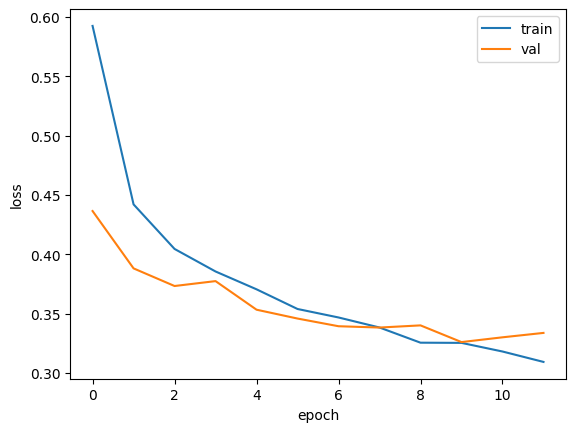

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [37]:
model.evaluate(val_scaled, val_target)
# 조기종료로 얻은 모델의 검증세트에 대한 성능 확인

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8878 - loss: 0.3256


[0.32606270909309387, 0.8845833539962769]